# Compare AstroGK linear simulation with analytic solution when $A_\parallel=0$

In [22]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from gk_solver.gk_apar0 import dispersion, res_0, res_i
from gk_solver.util import real_imag, list2complex
%matplotlib inline

###  Set plasma parameters

In [23]:
ti_te = 1
# ti_te = 0.01
kperp_rhoi = 0.1
wbar_0 = .13
bi = 0.01
bpar0 = 10
mi_me = 1836

### find eigen-frequencies

In [24]:
f = lambda w_bar: real_imag(dispersion(ti_te, mi_me, bi, kperp_rhoi, list2complex(w_bar)))

In [25]:
guess_1 = np.sqrt(bi) * 1.4 * (1 - 0.5j) # --> slow mode
res = scipy.optimize.fsolve(f, real_imag(guess_1))
wbar_1 = list2complex(res)
print(wbar_1)

(0.144803522515-0.0635943520342j)


## function to contruct time series easily

In [26]:
def ts_constructor(ti_te, mi_me, bi, kperp_rhoi, 
                   wbar_0, wbar_arr, tbar_arr, turnoff=None):
    """
    return time series for B_parallel and phi
    """
    
    def phi_b(tbar):
        """
            vector(\phi(t), B(t))
    """
        res = res_0(ti_te, mi_me, bi, kperp_rhoi, wbar_0, tbar, turnoff=turnoff)
        for wbar_i in wbar_arr:
            res += res_i(ti_te, mi_me, bi, kperp_rhoi, wbar_0, wbar_i, tbar, turnoff=turnoff)
        return res
    
    phi_b_arr = np.array([phi_b(tbar) for tbar in tbar_arr])
    return phi_b_arr

In [27]:
def eigenmode_finder(ti_te, mi_me, bi, kperp_rhoi):
    """
    find the eigenmodes of the gk system.
    currently hard coded the initial values for beta_i << 1, Ti = Te.
    """
    # slow mode
    guess_sm_1 = np.sqrt(bi) * 1.4 * (1-0.5j)
    guess_sm_2 = np.sqrt(bi) * 1.4 * (-1-0.5j)
    # entropy mode
    guess_sm_3 = (-0.2 * np.log10(bi) -0.58) * 1j

    f = lambda w_bar: real_imag(dispersion(ti_te, mi_me, bi, kperp_rhoi, list2complex(w_bar)))
    wbar_arr = []
    for guess in [guess_sm_1, guess_sm_2, guess_sm_3]:
        res = scipy.optimize.fsolve(f, real_imag(guess))
        wbar = list2complex(res)
        if np.abs(wbar.real) < 1.e-10:
            wbar = 1j * wbar.imag
        wbar_arr += [wbar]
    return wbar_arr

## plot system response for several different driving frequency

In [28]:
ti_te = 1

kperp_rhoi = 0.4
wbar0_arr = [0.1, 0.35, 0.4]
bi = 0.01
bpar0 = 10
mi_me = 1836

texts = "{0}{1}\n".format(r'$\beta_i$=',bi) + \
    "{0}{1}\n".format(r'$T_i/T_e=$',ti_te) + \
    "{0}{1}\n".format(r'$k_\perp \rho_i=$',kperp_rhoi) + \
    "{0}{1}\n".format(r'$\delta B_{\mathbf{k}\parallel 0}=$', bpar0)

In [29]:
wbar_arr = eigenmode_finder(ti_te, mi_me, bi, kperp_rhoi)
print(wbar_arr)

[(0.14076243337717911-0.067383584950148401j), (-0.14076243337717914-0.067383584950148401j), (-0-0.1866019662312864j)]


In [30]:
tbar_arr = np.linspace(0, 500, 500)

In [31]:
turnoff = 'ampere'
phi_bpar_arr = np.array([ts_constructor(ti_te, mi_me, bi, kperp_rhoi, 
                                        wbar_0, wbar_arr, tbar_arr, turnoff=turnoff) 
                         for wbar_0 in wbar0_arr])

In [32]:
phi_bpar_arr.shape

(3, 500, 2)

In [33]:
phi_arr = np.abs(phi_bpar_arr[:, :, 0])
bpar_arr = np.abs(phi_bpar_arr[:,:,1])

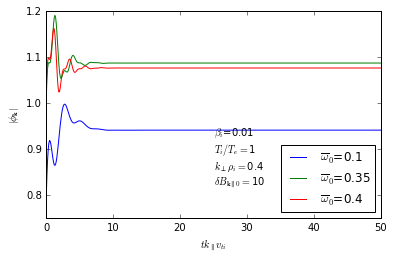

In [34]:
fig_phi_w0 = plt.figure(figsize=[6, 6*0.618])
for i in range(len(wbar0_arr)):
    plt.plot(tbar_arr * np.sqrt(bi), phi_arr[i, :] * bpar0, 
             label = '{0}={1}'.format(r'$\overline{\omega}_0$', wbar0_arr[i]))
# plt.ylim([0, 50])   
plt.legend(loc='best')
plt.xlabel('$tk_\parallel v_{ti}$')
plt.ylabel('$|\phi_{\mathbf{k}}|$')
ax = plt.gca()
plt.text(0.5, 0.1, texts, transform=ax.transAxes)
plt.show()

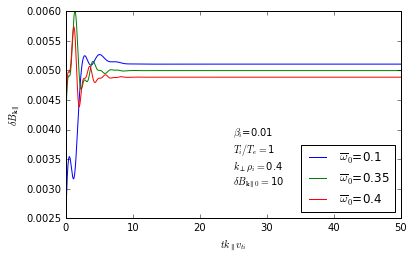

In [35]:
fig_bpar_w0 = plt.figure(figsize=[6, 6*0.618])
for i in range(len(wbar0_arr)):
    plt.plot(tbar_arr * np.sqrt(bi), bpar_arr[i, :] * bpar0, 
             label = '{0}={1}'.format(r'$\overline{\omega}_0$', wbar0_arr[i]))
plt.legend(loc='best')
plt.xlabel('$tk_\parallel v_{ti}$')
plt.ylabel('$\delta B_{\mathbf{k}\parallel}$')
ax = plt.gca()
plt.text(0.5, 0.1, texts, transform=ax.transAxes)

In [15]:
# fig_phi_w0.savefig('fig_phi_w0_2.eps')
# fig_bpar_w0.savefig('fig_bpar_w0_2.eps')

## compare with AstroGK simulation

In [16]:
data_dir = '/Volumes/yuguang_sd/data/agk/lin_response/lin_slow_1'
i = 4
filename_bpar = data_dir + '/lin_slow_{0:s}.bpar'.format(str(i))
filename_phi = data_dir + '/lin_slow_{0:s}.phi'.format(str(i))

In [17]:
dtype_bpar = {'names': ('f1', 't', 'f2', 'bpar2', 'f3', 'f4', 'h1', 'h2'),
              'formats': ('S2', 'f4', 'S10', 'f4', 'S10', 'S10', 'f4', 'f4')}
dtype_phi = {'names': ('f1', 't', 'f2', 'phi2', 'f3', 'f4', 'h1', 'h2'),
              'formats': ('S2', 'f4', 'S10', 'f4', 'S10', 'S10', 'f4', 'f4')}
data_bpar = np.loadtxt(filename_bpar, dtype = dtype_bpar)
data_phi = np.loadtxt(filename_phi, dtype = dtype_bpar)

In [18]:
def readColumn(data, column):
    return np.array([elem[column] for elem in data])

In [19]:
bpar = np.sqrt(readColumn(data_bpar, 3))
t_bpar = readColumn(data_bpar, 1)
phi = np.sqrt(readColumn(data_phi, 3))
t_phi = readColumn(data_phi, 1)

In [20]:
dt_label='0.01'
texts = "{0}{1}\n".format(r'$\beta_i=$',bi) + \
    "{0}{1}\n".format(r'$T_i/T_e=$',ti_te) + \
    "{0}{1:.1f}\n".format(r'$k_\perp \rho_i=$',kperp_rhoi) + \
    "{0}{1:.1f}\n".format(r'$\delta B_{\mathbf{k}\parallel 0}=$', bpar0) +\
    "{0}{1:.1f}\n".format(r'$\overline{\omega}_0=$',wbar_0)

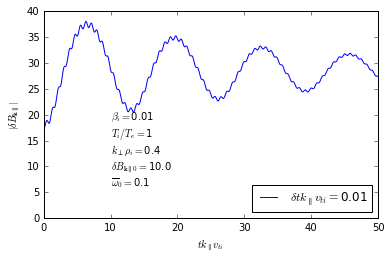

In [21]:
fig_bpar = plt.figure(figsize=[6, 6*0.618])
plt.plot(t_bpar, bpar * np.sqrt(8) * 10, label = '$\delta t k_\parallel v_{ti}=$' + dt_label)
plt.xlabel('$tk_\parallel v_{ti}$')
plt.ylabel('$|\delta B_{\mathbf{k}\parallel}|$')
plt.legend(loc='lower right')
ax = plt.gca()
plt.text(0.2, 0.1, texts, transform=ax.transAxes)